In [ ]:
%pip install transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from transformers import pipeline

from nltk import sent_tokenize
import nltk
from time import time
import matplotlib.pyplot as plt
import torch

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arnob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
subtitles_paths = sorted(glob("data/Subtitles/*.ass"))

In [6]:
scripts = []
episode_num = []

for path in subtitles_paths:

    with open(path, "r") as file:
        lines = file.readlines()
        lines = lines[27:]

        rows = [",".join(line.split(",")[9:1]) for line in lines]

    rows = [line.replace("\\N", " ") for line in rows]
    script = " ".join(rows)

    episode = int(path.split("-")[1].split(".")[0].strip())

    scripts.append(script)
    episode_num.append(episode)

In [7]:
df = pd.DataFrame.from_dict({'episode':episode_num, 'script':scripts})
df.head()

,episode,script


In [8]:
device = 0 if torch.cuda.is_available() else "cpu"

In [9]:
from transformers import pipeline

theme_classifier = pipeline(
    "zero-shot-classification", model="facebook/bart-large-mnli", device=device
)

c:\Users\arnob\OneDrive\Desktop\Projects\shinobinet\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arnob\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falli

In [10]:
theme_classifier(
    "I have a problem with my iphone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
    multi_label=False,
)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'],
 'scores': [0.5227569937705994,
  0.4581414759159088,
  0.014264528639614582,
  0.0026850125286728144,
  0.002152055036276579]}

In [11]:
def get_themes(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences
    script_batches = []
    sentence_batch_size = 20
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index : index + sentence_batch_size])
        script_batches.append(sent)

    # Run model
    candidate_labels = [
        "friendship",
        "hope",
        "sacrifice",
        "battle",
        "self development",
        "betrayal",
        "love",
        "dialogue",
    ]
    emotion_output = theme_classifier(
        script_batches, candidate_labels, multi_label=True
    )

    # Wrangle Output
    emotions = {}
    for output in emotion_output:
        for label, score in zip(output["labels"], output["scores"]):
            if label not in emotions:
                emotions[label] = []
            emotions[label].append(score)

    emotions = {key: np.mean(np.array(value)) for key, value in emotions.items()}

    return emotions

In [12]:
output_emotions = df["script"].apply(get_themes)

In [13]:
emotion_df = pd.DataFrame(output_emotions.tolist())


In [20]:
emotion_df.head()

""


In [15]:
df[emotion_df.columns] = emotion_df

In [17]:
print(df.columns)


Index(['episode', 'script'], dtype='object')


In [18]:
columns_to_drop = ["episode", "script", "dialogue"]
existing_columns = [col for col in columns_to_drop if col in df.columns]

theme_output = df.drop(existing_columns, axis=1).sum().reset_index()
theme_output.columns = ["theme", "score"]
theme_output

,theme,score


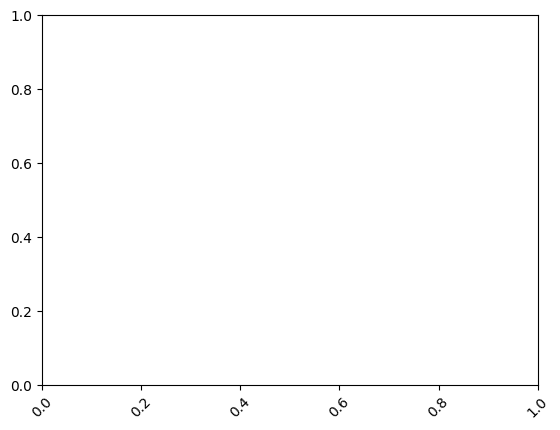

In [19]:
import seaborn as sns
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()